# Funnel Target: Compare SGLD and NVGD

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
import optax
key = random.PRNGKey(0)

import kernels
import metrics
# import seaborn as sns
# sns.set_theme()

# 2dim Funnel

In [2]:
n_steps = 500 # 5000
STEP_SIZE = 1e-2
META_LEARNING_RATE = 1e-3
d = 2
PATIENCE = 5
# PATIENCE = 15 # try this
NUM_SAMPLES = 200
MAX_TRAIN_STEPS = 100

In [3]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(NUM_SAMPLES)

compute_metrics = metrics.get_funnel_tracer(target_samples)

In [4]:
key, subkey = random.split(key)
init_particles = proposal.sample(NUM_SAMPLES)
opt = optax.sgd(STEP_SIZE)
sgld = utils.sgld(STEP_SIZE/10)
sgld_state = sgld.init(init_particles)

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               target_logp=target.logpdf,
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[32, 32, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               patience=PATIENCE,
                               dropout=True)

particles = models.Particles(subkey2,
                             neural_grad.gradient,
                             init_particles,
                             custom_optimizer=opt,
                             compute_metrics=compute_metrics)

* nonsense---instead, do nvgd and sgld step at the same time, on same particles, using same logp(x)s
* this is fine since sgld stepsize can (should) be smaller

In [5]:
key, subkey = random.split(key)


def nvgd_step(key):
    neural_grad.train(
        split_particles=particles.next_batch(key),
        n_steps=MAX_TRAIN_STEPS
    )
    particles.step(neural_grad.get_params())


@jit
def sgld_step(particles, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    step_losses, g = vmap(value_and_grad(utils.negative(target.logpdf)))(particles)
    g, sgld_state = sgld.update(g, sgld_state, particles)
    aux = {
        "losses": step_losses.mean(),
        "global_grad_norm": optax.global_norm(g),
    }
    particles = optax.apply_updates(particles, g)
    return particles, sgld_state, aux

In [6]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 1000
sgld_aux = {}
for step_counter in tqdm(range(num_steps)):
    key, subkey = random.split(key)
    nvgd_step(subkey)

#     SGLD step
    particles.particles, sgld_state, aux = sgld_step(
        particles.particles, sgld_state)
    metrics.append_to_log(sgld_aux, aux)

# neural_grad.done()
# particles.done()

100%|██████████| 1000/1000 [07:46<00:00,  2.15it/s]


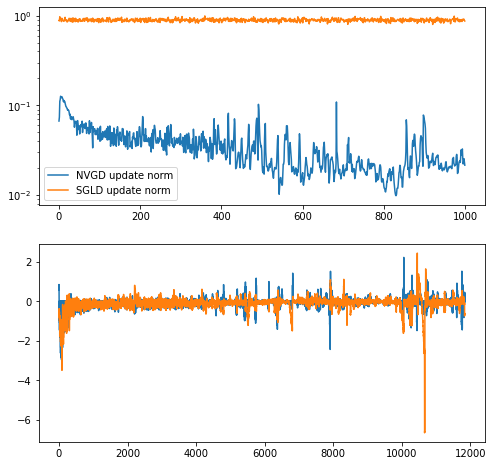

In [7]:
%matplotlib inline
fig, axs = plt.subplots(2, 1, figsize = [8,8])

ax = axs[0]
ax.plot(particles.rundata['global_grad_norm_post_update'], label="NVGD update norm")
ax.plot(sgld_aux['global_grad_norm'], label="SGLD update norm")
ax.set_yscale('log')
ax.legend()

ax = axs[1]
ax.plot(neural_grad.rundata["training_loss"])
ax.plot(neural_grad.rundata["validation_loss"])

In [8]:
sgld = utils.sgld(STEP_SIZE)


@jit
def sgld_step(particles, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    step_losses, g = vmap(value_and_grad(utils.negative(target.logpdf)))(particles)
    g, sgld_state = sgld.update(g, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "losses": step_losses.mean(),
        "global_grad_norm": optax.global_norm(g),
    }
    aux.update(compute_metrics(particles))
    return particles, sgld_state, aux

In [9]:
# just sgld
sgld_state = sgld.init(init_particles)
sgld_particles = init_particles
sgld_trajectory = [sgld_particles]
pure_sgld_aux = {}
for step_counter in tqdm(range(num_steps*2)):
    sgld_particles, sgld_state, aux = sgld_step(
        sgld_particles, sgld_state)
    metrics.append_to_log(pure_sgld_aux, aux)
    sgld_trajectory.append(sgld_particles)

# neural_grad.done()
# particles.done()

100%|██████████| 2000/2000 [00:03<00:00, 553.75it/s]


In [10]:
compute_metrics(particles.particles)

{'rbf_mmd': DeviceArray(6.8068504e-05, dtype=float32),
 'funnel_mmd': DeviceArray(0.0023452, dtype=float32)}

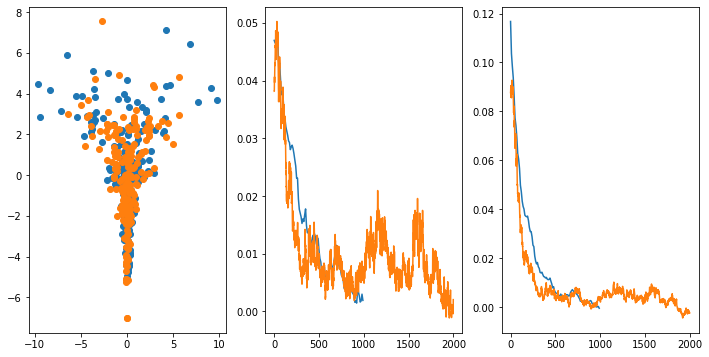

In [14]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=[12, 6])

ax = axs[0]
plot.scatter(sgld_particles, ax=ax)
plot.scatter(particles.particles, ax=ax)

ax = axs[1]
typ = "funnel_mmd"
ax.plot(*zip(*particles.rundata[typ]), label="NVGD")
ax.plot(pure_sgld_aux[typ], label="SGLD")

ax = axs[2]
typ = "rbf_mmd"
ax.plot(*zip(*particles.rundata[typ]), label="NVGD")
ax.plot(pure_sgld_aux[typ], label="SGLD")

In [19]:
%matplotlib widget
lims = (-15, 15)
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(*np.rollaxis(target.sample(NUM_SAMPLES), 1), label="True", alpha=0.25)
ax.set(xlim=lims, ylim=lims)


interval = 10
nvgd_traj = onp.array(particles.rundata['particles'])
sgld_traj = onp.array(sgld_trajectory)
a = []
a.append(plot.animate_array(nvgd_traj, fig, ax=ax, interval=interval))
a.append(plot.animate_array(sgld_traj, fig, ax=ax, interval=interval))
a

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
%matplotlib inline
plt.plot(*zip(*particles.rundata['funnel_mmd']));